In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import svm
from sklearn.inspection import permutation_importance
import math

In [17]:
df = pd.read_csv('loan_data.csv')

df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Need one hot encoding for the "purpose" column. Will use pandas dummies functionality to convert this categorical column:

In [18]:
df = pd.get_dummies(df)

df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


Standardize data (people have different loan feature amounts). Split into X and y:

In [19]:
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# MUST Standardize the data or else the SVM will not work- it will take forever to run.
X = StandardScaler().fit_transform(X)
# X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)


Calculate optimal proportion of "fully paid" (0) to "not fully paid" (1):

In [20]:
display(df['not.fully.paid'].value_counts())

display("Proportion of people fully paid => {}".format(1533/(1533 + 8045)))
display("Proportion of people not fully paid => {}".format(8045/(1533 + 8045)))

0    8045
1    1533
Name: not.fully.paid, dtype: int64

'Proportion of people fully paid => 0.16005429108373356'

'Proportion of people not fully paid => 0.8399457089162664'

'Log Reg Precision: 0.24820430965682364'

'Log Reg Recall: 0.6086105675146771'

'Log Reg F1: 0.35260770975056693'

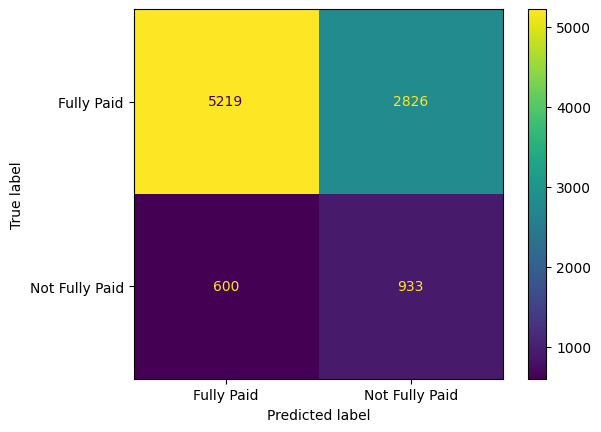

In [21]:
# Not fully paid = 0, fully paid = 1
# First attempting with all features and balanced class weight'
# Using liblinear instead of lfgs results in better prf scores & convergence issues

logReg = LogisticRegression(class_weight='balanced', solver='liblinear')
logReg.fit(X, y.values.ravel())

y_pred = logReg.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("Log Reg Precision: {}".format(p[0]))
display("Log Reg Recall: {}".format(r[0]))
display("Log Reg F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

Using customized class weights:

'Log Reg Precision: 0.24813829787234043'

'Log Reg Recall: 0.6086105675146771'

'Log Reg F1: 0.3525410920083129'

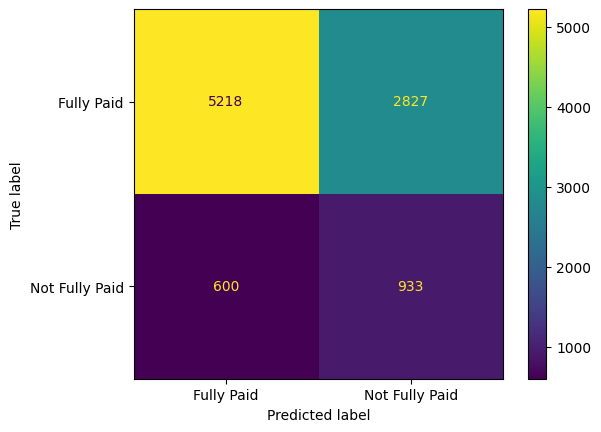

In [22]:
# Not fully paid = 0, fully paid = 1
# Attempting with all features and modified class weight
# Using liblinear instead of lfgs results in better prf scores & convergence issues

logReg = LogisticRegression(class_weight={0: 0.16, 1: 0.84}, solver='liblinear')
logReg.fit(X, y.values.ravel())

y_pred = logReg.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("Log Reg Precision: {}".format(p[0]))
display("Log Reg Recall: {}".format(r[0]))
display("Log Reg F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

Using fewer classes:

'Log Reg Precision: 0.24813829787234043'

'Log Reg Recall: 0.6086105675146771'

'Log Reg F1: 0.3525410920083129'

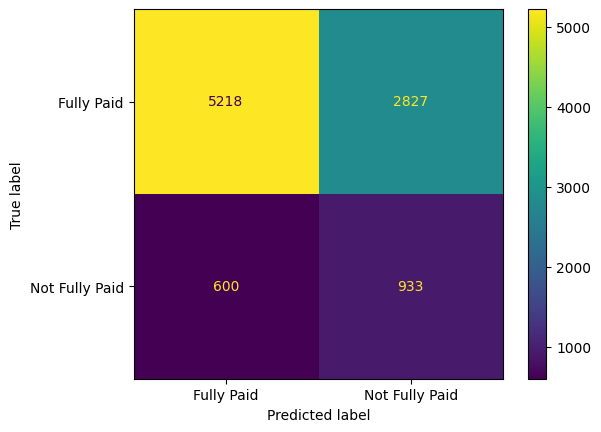

In [23]:
# Not fully paid = 0, fully paid = 1
# Attempting with all features and modified class weight
# Using liblinear instead of lfgs results in better prf scores & convergence issues

logReg = LogisticRegression(class_weight={0: 0.16, 1: 0.84}, solver='liblinear')
logReg.fit(X, y.values.ravel())

y_pred = logReg.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("Log Reg Precision: {}".format(p[0]))
display("Log Reg Recall: {}".format(r[0]))
display("Log Reg F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

SVM Using Linear Kernel:

'Linear SVM Precision: 0.2696245733788396'

'Linear SVM Recall: 0.5153294194390085'

'Linear SVM F1: 0.3540219583239973'

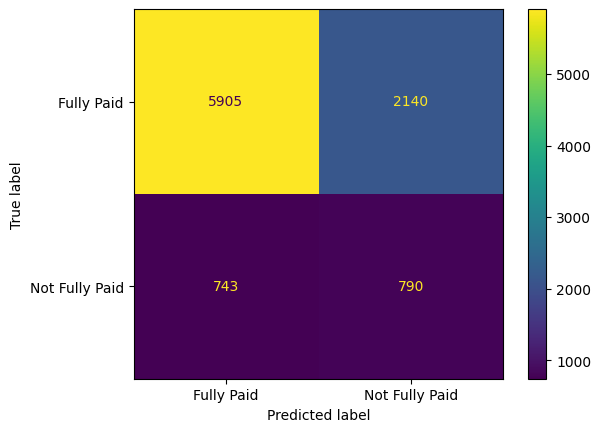

In [24]:
svmCLF = svm.SVC(kernel='linear', class_weight='balanced', gamma='auto')
svmCLF.fit(X, y.values.ravel())

y_pred = svmCLF.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("Linear SVM Precision: {}".format(p[0]))
display("Linear SVM Recall: {}".format(r[0]))
display("Linear SVM F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

Will now use polynomial kernel:

'Polynomial SVM Precision: 0.3265602322206096'

'Polynomial SVM Recall: 0.5870841487279843'

'Polynomial SVM F1: 0.41967824667754716'

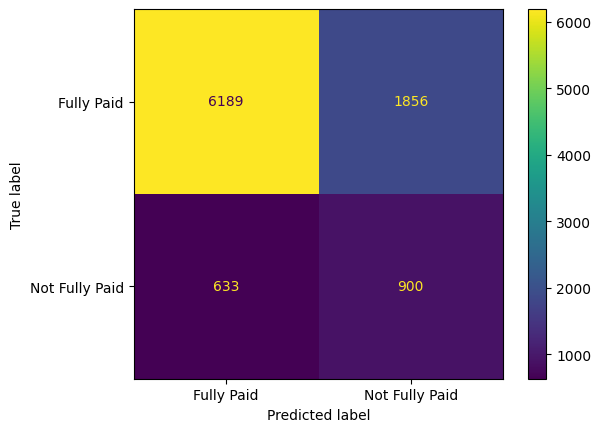

In [25]:
svmCLF = svm.SVC(kernel='poly', class_weight='balanced', gamma='auto', degree=3)
svmCLF.fit(X, y.values.ravel())

y_pred = svmCLF.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("Polynomial SVM Precision: {}".format(p[0]))
display("Polynomial SVM Recall: {}".format(r[0]))
display("Polynomial SVM F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

Will now use RBF kernel:

'RBF SVM Precision: 0.8978145304193739'

'RBF SVM Recall: 0.9915198956294846'

'RBF SVM F1: 0.9423434593924365'

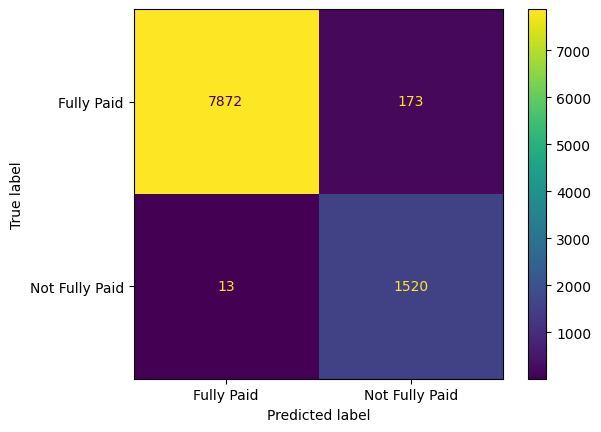

In [26]:
svmCLF = svm.SVC(kernel='rbf', class_weight='balanced', gamma=1)
svmCLF.fit(X, y.values.ravel())

y_pred = svmCLF.predict(X)
p, r, f, s = precision_recall_fscore_support(y, y_pred, labels=[1])
display("RBF SVM Precision: {}".format(p[0]))
display("RBF SVM Recall: {}".format(r[0]))
display("RBF SVM F1: {}".format(f[0]))

# Credit to w3schools for the confusion matrix code
confusion_matrix = metrics.confusion_matrix(y, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fully Paid', 'Not Fully Paid'])
cm_display.plot()
plt.show()

Text(0, 0.5, 'Interest Rate')

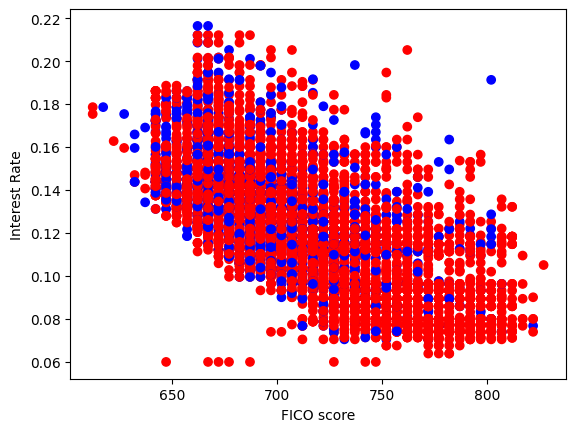

In [27]:
color = ['r' if y_ == 0 else 'b' for y_ in y]
plt.scatter(df.fico, df[['int.rate']], c=color)
plt.xlabel('FICO score')
plt.ylabel('Interest Rate')

Text(0, 0.5, 'Interest Rate')

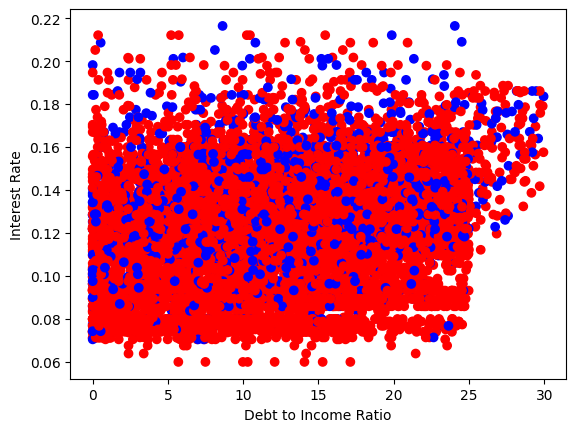

In [30]:
color = ['r' if y_ == 0 else 'b' for y_ in y]
plt.scatter(df.dti, df[['int.rate']], c=color)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Interest Rate')

Text(0, 0.5, 'Revolving Balance Utilization')

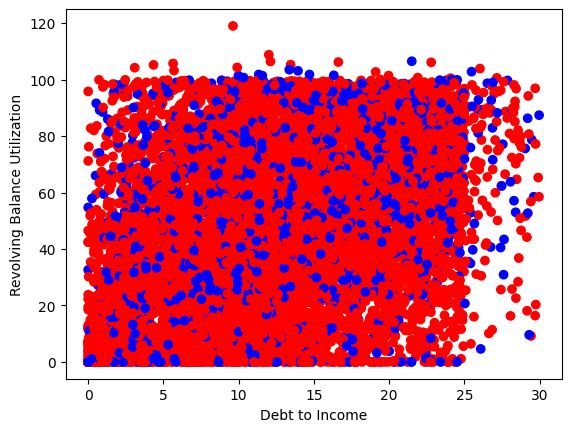

In [29]:
color = ['r' if y_ == 0 else 'b' for y_ in y]
plt.scatter(df.dti, df[['revol.util']], c=color)
plt.xlabel('Debt to Income')
plt.ylabel('Revolving Balance Utilization')